### Importaciones / Instalaciones

In [2]:
!pip install statsmodels==0.12.2 # The 0.13 stable version has some problems in SARIMAX
!pip install pmdarima # Instalación de paquete para auto_arima utilizado después
!pip install scikit-learn -U # Actualizar sklearn para metrica MAPE

     |████████████████████████████████| 9.5 MB 22.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.4 MB 24.4 MB/s 


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8) # Establecer así el tamaño de todas las figuras que se generan inderectamente con Matplotlib cuando el método no permite figsize

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pmdarima import auto_arima

### Utilidades

In [4]:
def eval_predictions(actual_s, predicted_s):
    """
    Recibe las series de valores actuales y predichos y calcula las métricas 
    MAE, RMSE y MAPE
    """
    mae = MAE(actual_s.values, predicted_s.values)
    rmse = np.sqrt(MSE(actual_s.values, predicted_s.values))
    mape = MAPE(actual_s.values, predicted_s.values)
    display(pd.DataFrame(data=[mae, rmse, mape], index=['MAE', 'RMSE', 'MAPE']).T)

def stationarity_test(s, significance_percent=5):
    """
    Recibe las series y reaiza el test ADF y KPSS y según sus resultados printa las conclusiones sobre la
    estacionareidad de la serie de entrada s.
    """
    result_adf = tsa.adfuller(s.dropna()) # Valores por defecto razonables
    result_kpss = tsa.kpss(s.dropna(), regression='c') # Valores por defecto razonables (regression c para que no se considere estacionarias con trend lineal)

    # Los p-values son el segundo elemento de los resultados devuetos
    alpha = significance_percent/100
    if result_adf[1] <= alpha:                               # ADF "acepta" Estacionaria (rechaza No Estacionaria)
        if result_kpss[1] > alpha:                           # KPSS "acepta" Estacionaria (falla en rechazar Estacionaria)
            print("-- Estacionaria con alta probabilidad --")
        else:                                                # KPSS rechaza Estacionaria
            print("-- No hay suficentes muestras (posible RW de baja potencia: otra diferenciacion?) --")
    else:                                                    # ADF "acepta" No-Estacionaria  (falla rechazar No-estacionaria)
        if result_kpss[1] > alpha:                           # KPSS "acepta" Estacionaria (falla en rechazar Estacionaria)
            print("-- Potencial problema de Varianza --")
        else:                                                # KPSS rechaza Estacionaria
            print("-- NO Estacionaria con alta probabilidad --")

### Carga del Dataset

In [5]:
# Air Passengers: Dataset de Box & Jenkins con el número total de pasajeros internacionales mensuales de 1949 a 1960
air_passengers_share = "https://drive.google.com/file/d/1UQuel7m_98HEzKkDiWlxXDcr-ftimvqT/view?usp=sharing"
url ='https://drive.google.com/uc?id=' + air_passengers_share.split('/')[-2]
air_df = pd.read_csv(url).rename(columns={"Thousands of Passengers":"Pasajeros"}) # Renombrado por comodidad!!!!!!!!!!!
air_df['Month'] = pd.to_datetime(air_df['Month'])
air_df.set_index('Month', drop=True, inplace=True)
air_df.index.freq = 'MS'
air_df.head()

,Pasajeros
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# StatsModels

## 3.1 
Grafica los **componentes ETS** de `air_df` tanto de forma **multiplicativa** como **aditiva**  
  * A: ¿Cual es la más apropiada viendo los **residuos**?

**Nota**
 * Las respuesta a A ponlo como un comentario en el código en una celda al final
 * Se esperan **2 gráficas diferentes** que pueden realizarse en celdas distintas si se prefiere o con `display` dentro de la misma celda.




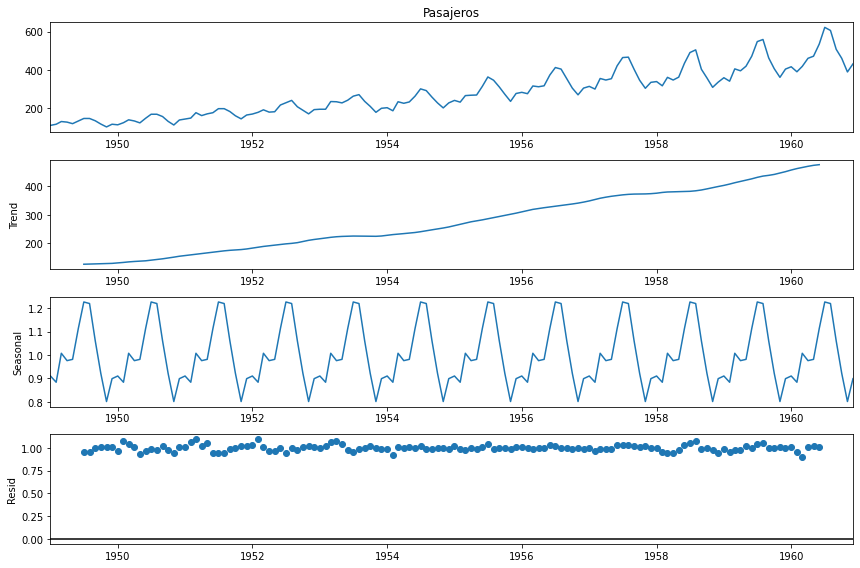

In [25]:
# Forma multiplicativa
air_multiplicativa = tsa.seasonal_decompose(air_df['Pasajeros'], model='multiplicative')
air_multiplicativa.plot();

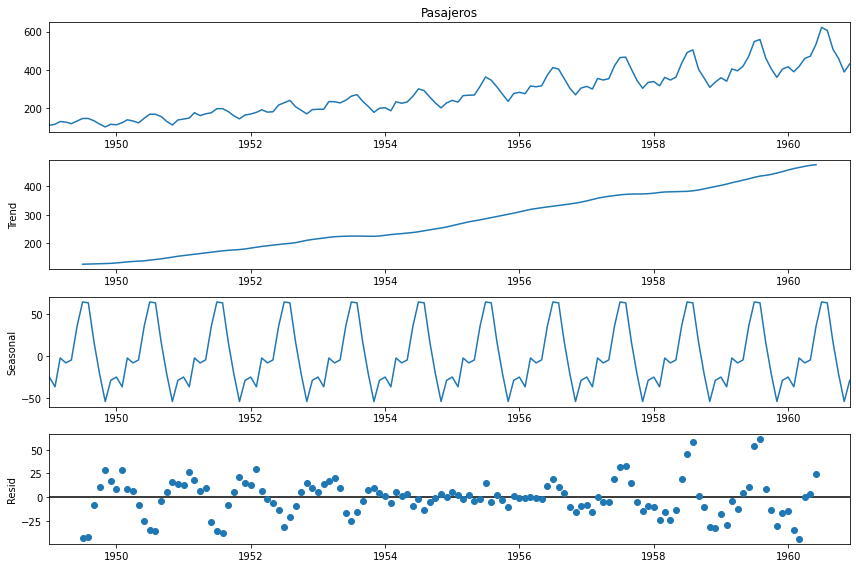

In [26]:
# Forma aditiva
air_aditiva = tsa.seasonal_decompose(air_df['Pasajeros'], model='additive') 
air_aditiva.plot();

In [ ]:
# A: ¿Cual es la más apropiada viendo los residuos? 
# Viendo los residuos la mas adecuada es la forma multiplicativa

## 3.2 
Realiza y grafica un **Train - Eval split** con el **último año** (los últimos 12 meses) como conjunto de evaluación.

**Nota**  
  * Pon leyenda y etiquetas en los ejes y título de la gráfica

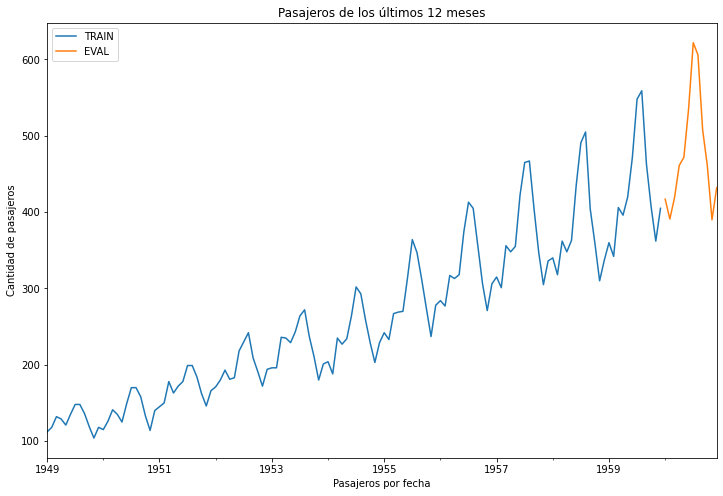

In [27]:
# Train - Test Split
eval_points = 12
split_point = len(air_df) - eval_points

air_df_train = air_df.iloc[:split_point] # Split point no incluido en el Training
air_df_eval = air_df.iloc[split_point:]
ax = air_df_train['Pasajeros'].plot(legend=True,label='TRAIN')
air_df_eval['Pasajeros'].plot(legend=True,label='EVAL',figsize=(12,8), ax=ax);
ax.set_xlabel("Pasajeros por fecha") 
ax.set_ylabel("Cantidad de pasajeros")
ax.set_title("Pasajeros de los últimos 12 meses");

## 3.3 
Modela el data set de Train con 3 **modelos ETS** que consideres apropiados.
  * Grafica en una sola gráfica lo siguiente:  
    * El dataset de Train **SIN los fitted values** de los modelos elegidos
    * El dataset de Evaluación **CON las predicciones de los modelos elegidos**
  * Evalúa con la métrica **MAPE** los modelos elegidos y seleccionar el que mejor se comporta en el dataset de evaluación

**Nota**  
  * Escribir en una celda final con comentarios el modelo con mejor "performance" tras realizar la evaluación  
  * Se espera una sola gráfica donde el conjunto de Train se pinta solo sin los `fitted` values pintados encima (a diferencia de como está hecho en el NB de teoría) y el conjunto de Eval se pinta el mas las predicciones de los modelos elegidos (es decir, 1 + 3 = 4 curvas en la zona de Eval, al igual que en el NB de teoría)

**Pista**
  * La Serie temporal del ejercicio **tiene seasonality** con lo que eso **descarta** muchos modelos ETS que no son capaces de modelar la seasonalidad, que de los 3 elegidos **ninguno** sea un modelo que no incorpore seasonalidad si no distintas varianes de los que permiten seasonalidad.

Lineal-Lineal No Amortigüado


,MAE,RMSE,MAPE
0,21.544782,26.375763,0.051142


Lineal-Multiplicativa No Amortigüado


,MAE,RMSE,MAPE
0,22.629075,27.368062,0.050688


Lineal-Lineal Amortigüado


,MAE,RMSE,MAPE
0,23.103956,27.596994,0.056754


Lineal-Multiplicativa Amortigüado


,MAE,RMSE,MAPE
0,31.895753,41.433634,0.068834


,Lineal-Lineal No Amortigüado,Lineal-Multiplicativa No Amortigüado,Lineal-Lineal Amortigüado,Lineal-Multiplicativa Amortigüado
0,0.051142,0.050688,0.056754,0.068834


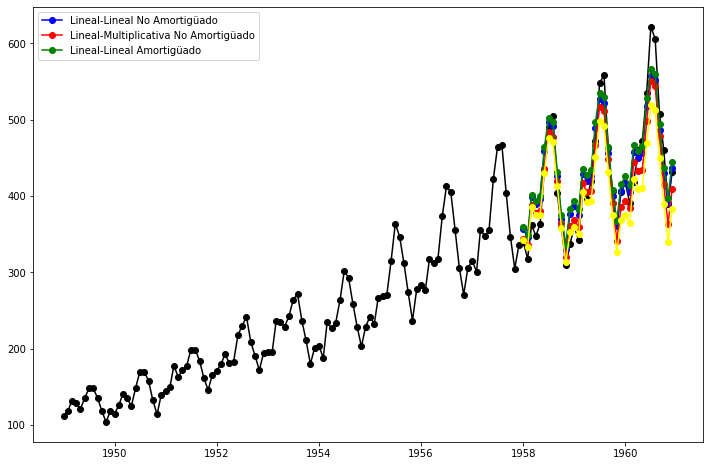

In [34]:
# ""El modelo elegido fue Triple Exponential Smoothing (TES) porque es el que tiene seasonality""

# Creación de los Modelos 
fit1 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
fcast1 = fit1.forecast(eval_points).rename("Lineal-Lineal No Amortigüado")
fit2 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=12, trend='add', seasonal='mul', initialization_method="estimated").fit()
fcast2 = fit2.forecast(eval_points).rename("Lineal-Multiplicativa No Amortigüado")
fit3 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(eval_points).rename("Lineal-Lineal Amortigüado")
fit4 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True, initialization_method="estimated").fit()
fcast4 = fit4.forecast(eval_points).rename(r"Lineal-Multiplicativa Amortigüado")


plt.figure(figsize=(12, 8))
plt.plot(air_df_train['Pasajeros'], marker='o', color='black')
plt.plot(air_df_eval['Pasajeros'], marker='o', color='black')
line1, = plt.plot(fcast1, marker='o', color='blue')
line2, = plt.plot(fcast2, marker='o', color='red')
line3, = plt.plot(fcast3, marker='o', color='green')
line4, = plt.plot(fcast4, marker='o', color='yellow')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

# Evaluacion
print("Lineal-Lineal No Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast1)

print("Lineal-Multiplicativa No Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast2)

print("Lineal-Lineal Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast3)

print("Lineal-Multiplicativa Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast4)

# Metricas MAPE (Solo las metricas MAPE)
m1=MAPE(air_df_eval['Pasajeros'],fcast1)
m2=MAPE(air_df_eval['Pasajeros'],fcast2)
m3=MAPE(air_df_eval['Pasajeros'],fcast3)
m4=MAPE(air_df_eval['Pasajeros'],fcast4)

display(pd.DataFrame(data=[m1, m2, m3, m4],index=['Lineal-Lineal No Amortigüado', 'Lineal-Multiplicativa No Amortigüado', 'Lineal-Lineal Amortigüado','Lineal-Multiplicativa Amortigüado']).T)
print('\n')

In [ ]:
# Segun la metrica MAPE el modelo que mejor se comporta es el Lineal-Multiplicativa No Amortigüado.

## 3.4
Volver a realizar un **Train - Eval Split** pero ahora con los **3 últimos años**. 
Con el modelo **seleccionado** en el ejercicio anterior:  
  * Entrena con el nuevo dataset de Train
  * Grafica y evalua de nuevo en una gráfica lo siguiente (muy similar al ejercicio anterior):  
    * El dataset de Train **SIN los fitted values** del modelo
    * El dataset de Evaluación junto a la predicción

  * A: ¿Observas algún problema respecto al modelo anterior? ¿Empeora a largo plazo?
  * B: ¿A que crees que se debe?

Lineal-Lineal No Amortigüado


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


,MAE,RMSE,MAPE
0,36.791472,50.611018,0.077178


Lineal-Multiplicativa No Amortigüado


,MAE,RMSE,MAPE
0,23.352915,26.633259,0.054356


Lineal-Lineal Amortigüado


,MAE,RMSE,MAPE
0,47.697926,62.315249,0.100117


Lineal-Multiplicativa Amortigüado


,MAE,RMSE,MAPE
0,24.504289,28.008484,0.056914


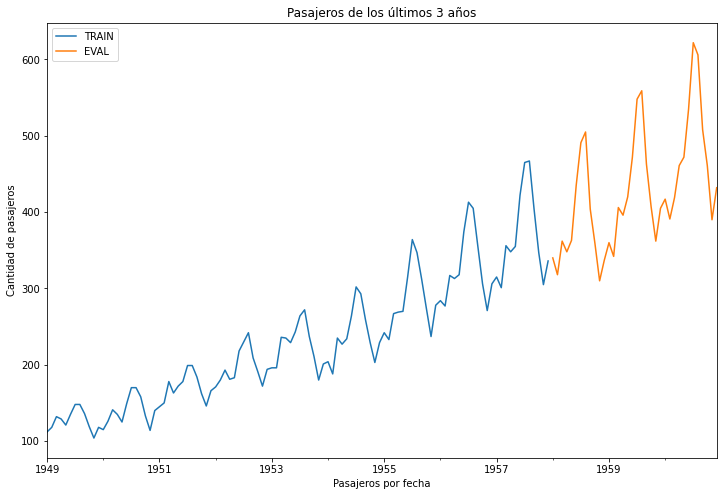

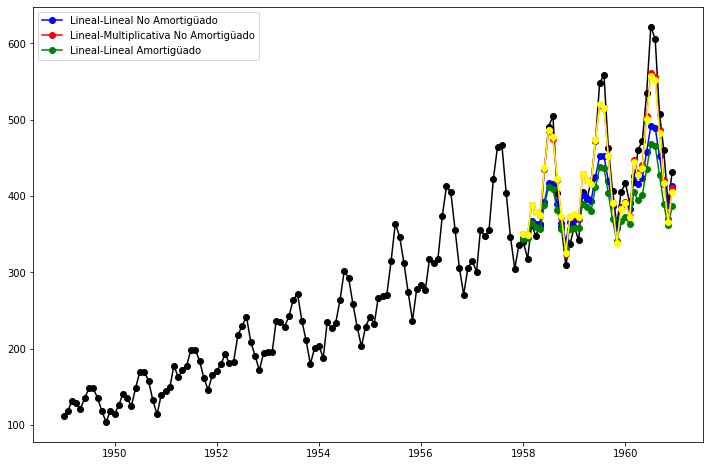

In [35]:
eval_points = 36
split_point = len(air_df) - eval_points

air_df_train = air_df.iloc[:split_point] # Split point no incluido en el Training
air_df_eval = air_df.iloc[split_point:]
ax = air_df_train['Pasajeros'].plot(legend=True,label='TRAIN')
air_df_eval['Pasajeros'].plot(legend=True,label='EVAL',figsize=(12,8), ax=ax);
ax.set_xlabel("Pasajeros por fecha") 
ax.set_ylabel("Cantidad de pasajeros")
ax.set_title("Pasajeros de los últimos 3 años");

# Creación de los Modelos 
fit1 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=36, trend='add', seasonal='add', initialization_method="estimated").fit()
fcast1 = fit1.forecast(eval_points).rename("Lineal-Lineal No Amortigüado")

# "Este es el Lineal-Multiplicativa No Amortigüado que dio mejor resultado MAPE en la metrica del ejercicio anterior"
fit2 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=36, trend='add', seasonal='mul', initialization_method="estimated").fit()
fcast2 = fit2.forecast(eval_points).rename("Lineal-Multiplicativa No Amortigüado")

fit3 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=36, trend='add', seasonal='add', damped_trend=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(eval_points).rename("Lineal-Lineal Amortigüado")
fit4 = tsa.ExponentialSmoothing(air_df_train['Pasajeros'], seasonal_periods=36, trend='add', seasonal='mul', damped_trend=True, initialization_method="estimated").fit()
fcast4 = fit4.forecast(eval_points).rename(r"Lineal-Multiplicativa Amortigüado")

plt.figure(figsize=(12, 8))
plt.plot(air_df_train['Pasajeros'], marker='o', color='black')
plt.plot(air_df_eval['Pasajeros'], marker='o', color='black')
plt.plot(color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
line4, = plt.plot(fcast4, marker='o', color='yellow')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

# Evaluacion
print("Lineal-Lineal No Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast1)

print("Lineal-Multiplicativa No Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast2)

print("Lineal-Lineal Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast3)

print("Lineal-Multiplicativa Amortigüado")
eval_predictions(air_df_eval['Pasajeros'],fcast4)

In [ ]:
# A: ¿Observas algún problema respecto al modelo anterior? ¿Empeora a largo plazo?
# Presentan un recorrido parecido y empeora a largo plazo y las predicciones van quedando por debajo de la evaluacion.

# B: ¿A que crees que se debe?
# Por la cantidad de variables que pueden afectar el desenvolvimiento de la predicción es mayor mientras más tiempo transcurre.

## 3.5 
Con el último dataset de train ((en el que se han quitado los últimos 3 años) utiliza **Auto-Arima** para modelar la serie temporal con un modelo SARIMA.

SARIMA(1,1,1)(0,1,1)


,MAE,RMSE,MAPE
0,18.050264,23.010838,0.041372


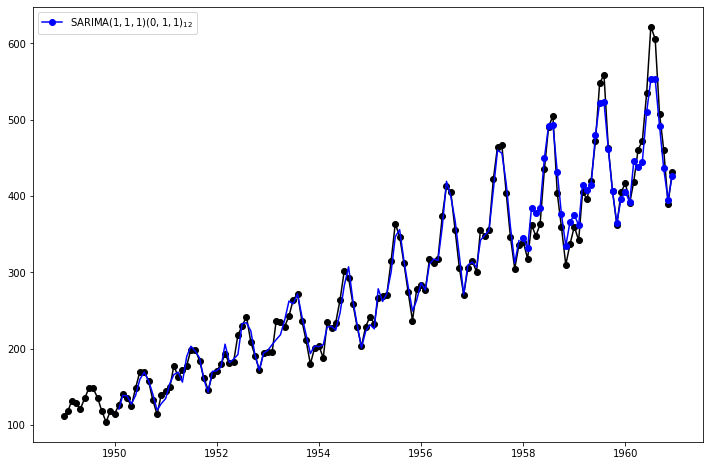

In [38]:
# Auto-Arima
auto_sarima_res = auto_arima(air_df_train['Pasajeros'], seasonal=True, m=12)
auto_sarima_res.summary()

# Modelo óptimo es SARIMA(1,1,1)(0,1,1)
fit = tsa.SARIMAX(air_df_train['Pasajeros'], order=(1,1,1), seasonal_order=(0, 1, 1, 12)).fit() 
fcast = pd.Series(fit.forecast(eval_points), index=air_df_eval.index, name="SARIMA$(1,1,1)(0,1,1)_{12}$")


plt.figure(figsize=(12, 8))
plt.plot(air_df_train['Pasajeros'], marker='o', color='black')
plt.plot(air_df_eval['Pasajeros'], marker='o', color='black')

plt.plot(fit.predict(typ='levels').iloc[13:], color='blue') # predict devuelve los valores estimados in-sample: typ=levels es para que sea sobre la original y no la diferenciada (burn los primeros 12 por la seasonality)
line, = plt.plot(fcast, marker='o', color='blue')

plt.legend([line], [fcast.name])

print("SARIMA(1,1,1)(0,1,1)")
eval_predictions(air_df_eval['Pasajeros'], fcast)